## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import sys
sys.path.insert(0,'/content/gdrive/MyDrive/Colab Notebooks/tictactoe')
from TCGame_Env import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [ ]:
## defining object for the Tic-tac-toe environment created as MDP in TCGame_env
env = TicTacToe()

In [ ]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [ ]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [ ]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

In [ ]:
# Printing the default tic-tac-toe board positions
Q_state(env.state)

'x-x-x-x-x-x-x-x-x'

In [ ]:
# Printing all the valid actions
valid_actions(env.state)

[(0, 1),
 (0, 3),
 (0, 5),
 (0, 7),
 (0, 9),
 (1, 1),
 (1, 3),
 (1, 5),
 (1, 7),
 (1, 9),
 (2, 1),
 (2, 3),
 (2, 5),
 (2, 7),
 (2, 9),
 (3, 1),
 (3, 3),
 (3, 5),
 (3, 7),
 (3, 9),
 (4, 1),
 (4, 3),
 (4, 5),
 (4, 7),
 (4, 9),
 (5, 1),
 (5, 3),
 (5, 5),
 (5, 7),
 (5, 9),
 (6, 1),
 (6, 3),
 (6, 5),
 (6, 7),
 (6, 9),
 (7, 1),
 (7, 3),
 (7, 5),
 (7, 7),
 (7, 9),
 (8, 1),
 (8, 3),
 (8, 5),
 (8, 7),
 (8, 9)]

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [ ]:
# Defining epsilon-greedy policy. You can choose any function for epsilon-decay strategy
def epsilon_greedy(state, time):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time)
    # print(epsilon)
    z = np.random.random()
        
    if z > epsilon:
        state1 = Q_state(state)
        action = max(Q_dict[state1],key=Q_dict[state1].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    else:
        possible_action = [i for i in env.action_space(state)[0]]        
        action = possible_action[np.random.choice(range(len(possible_action)))]    #Exploration: randomly choosing and action
    
    return action

#### Tracking the state-action pairs for checking convergence - write your code here

In [ ]:
# Initialise the Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track =collections.defaultdict(dict)

In [ ]:
Q_dict

defaultdict(dict, {})

In [ ]:
States_track

defaultdict(dict, {})

In [ ]:
# Initialise states to track
def initialise_tracking_states():
    Sample_Qvalues = [('x-x-x-x-x-x-x-x-x',(6,5)),('x-x-x-x-x-x-x-x-x',(1,9)),
                       ('x-3-x-x-4-x-x-x-x',(7,5)),('x-5-x-2-x-x-6-7-x',(8,3))]    #select some 4 Q-values
    for q_values in Sample_Qvalues:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []  
  
  
  

In [ ]:
initialise_tracking_states()

In [ ]:
States_track

defaultdict(dict,
            {'x-3-x-x-4-x-x-x-x': {(7, 5): []},
             'x-5-x-2-x-x-6-7-x': {(8, 3): []},
             'x-x-x-x-x-x-x-x-x': {(1, 9): [], (6, 5): []}})

In [ ]:
# Defining a function to dump the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

#### Define hyperparameters  ---write your code here

In [ ]:
#Defining parameters for the training

EPISODES = 500000
LR = 0.01                   # learning rate
GAMMA = 0.9                # discount factor

max_epsilon = 1.0
min_epsilon = 0.001
decay_rate = 0.001        # epsilon decay rate
threshold = 400       # no of episodes after which states_tracked will be saved
policy_threshold =  500   # no of episodes after which Q dictionary/table will be saved

### Q-update loop ---write your code here

In [ ]:
import time 
start_time = time.time()

for episode in range(EPISODES):
    env = TicTacToe() # call the environment
    curr_state = env.state    
    done = False  
    add_to_dict(curr_state)  # adding the current state to dictionary

    while done != True:  
        curr_state1 = Q_state(curr_state)
        curr_action = epsilon_greedy(curr_state, episode)   # applying epislon method
        next_state, reward, done = env.step(curr_state, curr_action) # getting rewar
        next_state_temp = Q_state(next_state)
        add_to_dict(next_state)


        

        # Updating rules
        if done != True:
            max_next = max(Q_dict[next_state_temp],key=Q_dict[next_state_temp].get)  
                #this gets the action corresponding to max q-value of next state
            Q_dict[curr_state1][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state_temp][max_next])))
                                                      - Q_dict[curr_state1][curr_action] ) 
        else:
            Q_dict[curr_state1][curr_action] += LR * ((reward - Q_dict[curr_state1][curr_action]))

        # navigating to next state
        curr_state = next_state
        
     #states tracking   
    if ((episode+1)%threshold)==0:
        save_tracking_states()
        save_obj(States_track,'States_tracking')
        print(episode) 

    if ((episode+1)% policy_threshold) == 0:  #every 300th episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy_Q_dict')  
        

elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracking')   
save_obj(Q_dict,'Policy_Q_dict')

399
799
1199
1599
1999
2399
2799
3199
3599
3999
4399
4799
5199
5599
5999
6399
6799
7199
7599
7999
8399
8799
9199
9599
9999
10399
10799
11199
11599
11999
12399
12799
13199
13599
13999
14399
14799
15199
15599
15999
16399
16799
17199
17599
17999
18399
18799
19199
19599
19999
20399
20799
21199
21599
21999
22399
22799
23199
23599
23999
24399
24799
25199
25599
25999
26399
26799
27199
27599
27999
28399
28799
29199
29599
29999
30399
30799
31199
31599
31999
32399
32799
33199
33599
33999
34399
34799
35199
35599
35999
36399
36799
37199
37599
37999
38399
38799
39199
39599
39999
40399
40799
41199
41599
41999
42399
42799
43199
43599
43999
44399
44799
45199
45599
45999
46399
46799
47199
47599
47999
48399
48799
49199
49599
49999
50399
50799
51199
51599
51999
52399
52799
53199
53599
53999
54399
54799
55199
55599
55999
56399
56799
57199
57599
57999
58399
58799
59199
59599
59999
60399
60799
61199
61599
61999
62399
62799
63199
63599
63999
64399
64799
65199
65599
65999
66399
66799
67199
67599
67999
68399
6

#### Check the Q-dictionary

In [ ]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.122839039932377,
              (0, 3): -1.1230058113136434,
              (0, 5): -1.122867304743278,
              (0, 7): -1.1228219075078345,
              (0, 9): -1.1229813008292346,
              (1, 1): -1.1228297270859402,
              (1, 3): -1.1228521392557975,
              (1, 5): -1.123027191883048,
              (1, 7): -1.122820553277447,
              (1, 9): -1.1228837276183081,
              (2, 1): -1.1228605897084027,
              (2, 3): -1.1230770078743053,
              (2, 5): -1.1228666075144802,
              (2, 7): -1.1230899107054748,
              (2, 9): -1.1228873137205646,
              (3, 1): -1.1229290836071617,
              (3, 3): -1.1228563766320951,
              (3, 5): -1.1229557783859017,
              (3, 7): -1.1228683301273128,
              (3, 9): -1.1228198040430504,
              (4, 1): -1.1229188100625647,
              (4, 3): -1.1229860083788576,
              (4, 5

In [ ]:
len(Q_dict)

838935

In [ ]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated

#### Check the states tracked for Q-values convergence
(non-evaluative)

In [ ]:
# Write the code for plotting the graphs for state-action pairs tracked

<function matplotlib.pyplot.show>

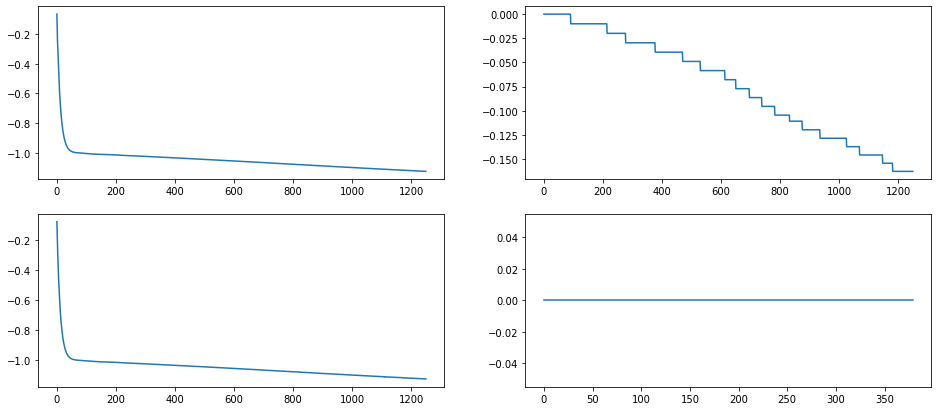

In [ ]:
plt.figure(0, figsize=(16,7))

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(6,5)])))
plt.subplot(221)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(6,5)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-3-x-x-4-x-x-x-x'][(7,5)])))
plt.subplot(222)
plt.plot(x_axis,np.asarray(States_track['x-3-x-x-4-x-x-x-x'][(7,5)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(1,9)])))
plt.subplot(223)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(1,9)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-5-x-2-x-x-6-7-x'][(8,3)])))
plt.subplot(224)
plt.plot(x_axis,np.asarray(States_track['x-5-x-2-x-x-6-7-x'][(8,3)]))
plt.show

### Epsilon - decay check

In [ ]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

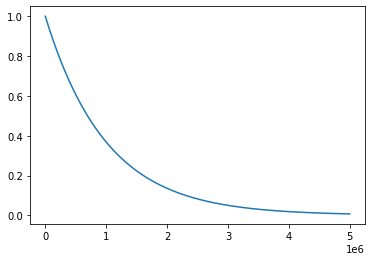

In [ ]:
# Plotting the decay
plt.plot(time, epsilon)
plt.show()